# Organize mined tweets
In which we dump all tweets related to a certain hashtag (`#Harvey, #Irma, #HurricaneHarvey, #HurricaneIrma`) or a certain place to file for sanity purposes.

File format:

tweet_id | username | text | date | retweet | place | geo

## Load separate historical tweets

In [273]:
import os
from datetime import datetime, timedelta
import gzip
import pandas as pd
data_dir = '../../data/mined_tweets/'
hashtags = ['#Irma', '#HurricaneIrma', '#Harvey', '#HurricaneHarvey']
hashtag_str = ','.join(hashtags)
start_date_str = '2017-08-20'
end_date_str = '2017-09-10'
date_fmt = '%Y-%m-%d'
start_date = datetime.strptime(start_date_str, date_fmt)
end_date = datetime.strptime(end_date_str, date_fmt)
day_count = (end_date - start_date).days
all_dates = [start_date + timedelta(days=i) for i in range(day_count+1)]
all_dates_str = [datetime.strftime(x, date_fmt) for x in all_dates]
start_end_dates_str = zip(all_dates_str[:-1], all_dates_str[1:])
historical_tweet_df_combined = []
for start_date_str, end_date_str in start_end_dates_str:
    tweet_file = os.path.join(data_dir, '%s_%s_%s.gz'%(hashtag_str, start_date_str, end_date_str))
    with gzip.open(tweet_file, 'r') as tweet_input:
        tweet_rows = [l.strip().split('\t') for l in tweet_input]
        historical_tweet_df = pd.DataFrame(tweet_rows)
        historical_tweet_df.columns = historical_tweet_df.iloc[0, :]
        historical_tweet_df.drop(0, axis=0, inplace=True)
        historical_tweet_df_combined.append(historical_tweet_df)
historical_tweet_df_combined = pd.concat(historical_tweet_df_combined, axis=0)
print('%d historical tweets collected'%(historical_tweet_df_combined.shape[0]))

1422060 historical tweets collected


In [274]:
# delete duplicates
historical_tweet_df_combined.loc[:, 'id'] = historical_tweet_df_combined.loc[:, 'id'].apply(lambda x: int(x.replace('"','')))
historical_tweet_df_combined.drop_duplicates('id', inplace=True)
print('%d non-duplicate tweets'%(historical_tweet_df_combined.shape[0]))

1421174 non-duplicate tweets


In [275]:
print(historical_tweet_df_combined.loc[:, 'date'].values[0])

2017-08-19 16:47


In [276]:
# time distribution per day
day_fmt = '%m-%d-%Y'
date_fmt = '%Y-%m-%d %H:%M'
historical_tweet_df_dates = historical_tweet_df_combined.loc[:, 'date'].apply(lambda x: datetime.strptime(x, date_fmt))
historical_tweet_df_date_day = historical_tweet_df_dates.apply(lambda x: datetime.strftime(x, day_fmt))
historical_tweet_df_combined = historical_tweet_df_combined.assign(date_day=historical_tweet_df_date_day)

In [277]:
historical_tweet_df_date_counts = historical_tweet_df_date_day.value_counts().sort_index(inplace=False)
print(historical_tweet_df_date_counts)

08-19-2017       219
08-20-2017       495
08-21-2017       454
08-22-2017      1215
08-23-2017      5654
08-24-2017     40547
08-25-2017    110856
08-26-2017     55846
08-27-2017     85091
08-28-2017    105063
08-29-2017    111906
08-30-2017     83596
08-31-2017     60257
09-01-2017     44198
09-02-2017     35667
09-03-2017     24594
09-04-2017     12604
09-05-2017    102766
09-06-2017    142156
09-07-2017    136390
09-08-2017    139337
09-09-2017    122263
Name: date, dtype: int64


## Load historical tweets
**SKIP THIS** just keeping for debugging purposes.

From GetOldTweets.

This file is messy because I didn't separate tweets by character returns, so we'll have to do a bit of cleaning.

In [3]:
import gzip
historical_tweet_file = '../../data/hurricane_data.gz'
historical_tweet_str = [l.strip() for l in gzip.open(historical_tweet_file, 'r')]

In [4]:
print(len(historical_tweet_str))

2


In [6]:
print(historical_tweet_str[0])

username	date	retweets	favorites	text	geo	mentions	hashtags	permalink


In [7]:
historical_tweet_str = reduce(lambda x,y: x+y, [l.split('\t') for l in historical_tweet_str])

In [11]:
print(historical_tweet_str[:9])
print(len(historical_tweet_str))

['username', 'date', 'retweets', 'favorites', 'text', 'geo', 'mentions', 'hashtags', 'permalink']
2559610


One more preprocessing thing: we need to separate permalinks and usernames, which got stuck together somehow. 

In [28]:
import re
historical_tweet_row_list = []
row_len = 10
username_matcher = re.compile('(?<=[0-9]{18})\w+')
url_matcher = re.compile('https://twitter.com/\w+/status/[0-9]{18}\w+')
for i, r in enumerate(historical_tweet_str[9:]):
    if(url_matcher.findall(r)):
        # split permalink and username!
        username = username_matcher.findall(r)[0]
        permalink = r.replace(username, '')
        historical_tweet_row_list.append(permalink)
        historical_tweet_row_list.append(username)
    else:
        historical_tweet_row_list.append(r)
print(historical_tweet_row_list[:20])

['diane380', '2017-09-11 19:59', '0', '0', '"Je sais pas mais je trouve qu il est stress\xc3\xa9, nerveux, a la limite \'b\xc3\xaate\' ? Je l \xc3\xa9coute pas souvent ! P.e. la fatigue de la couverture #Irma"', '', '', '#Irma', '"907393316832071680"', 'https://twitter.com/diane380/status/907393316832071680', 'mccranie_paul', '2017-09-11 19:59', '0', '6', '"I am wildly bored. #HurricaneIrma"', '', '', '#HurricaneIrma', '"907393316463026177"', 'https://twitter.com/mccranie_paul/status/907393316463026177']


Group the data and assume each group is a separate line.

In [29]:
row_len = 10
row_count = len(historical_tweet_row_list) / row_len
historical_tweet_rows = [historical_tweet_row_list[i*row_len:(i+1)*row_len] for i in range(row_count)]

In [36]:
import pandas as pd
cols = historical_tweet_str[:8] + ['id'] + [historical_tweet_str[8]]
historical_tweet_df = pd.DataFrame(historical_tweet_rows, columns=cols)
print(historical_tweet_df.head())

         username              date retweets favorites  \
0        diane380  2017-09-11 19:59        0         0   
1   mccranie_paul  2017-09-11 19:59        0         6   
2  HartfordNHNews  2017-09-11 19:59        0         0   
3      jpreiser93  2017-09-11 19:59        2         7   
4     PoliticalQB  2017-09-11 19:59        0         0   

                                                text geo mentions  \
0  "Je sais pas mais je trouve qu il est stressé,...                
1                "I am wildly bored. #HurricaneIrma"                
2  "A 360-degree tour of the damage caused by #Hu...                
3  "I will never take electricity for granted eve...                
4  "Hurricane expert Klotzbach: #Irma at landfall...                

                                      hashtags                    id  \
0                                        #Irma  "907393316832071680"   
1                               #HurricaneIrma  "907393316463026177"   
2                   

In [45]:
print('%d tweets total'%(historical_tweet_df.shape[0]))

284400 tweets total


In [44]:
print('earliest historical tweet date = %s'%(historical_tweet_df['date'].min()))

earliest historical tweet date = 2017-09-10 08:59


Let's also check the more recent hashtag-only search.

In [40]:
historical_tweet_file_hashtags = '../../data/#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_2017-08-17_2017-09-14.gz'
historical_tweet_hashtags_data = [l.strip().split('\t') for l in gzip.open(historical_tweet_file_hashtags)]
historical_tweet_hashtags_df = pd.DataFrame(historical_tweet_hashtags_data[1:], columns=historical_tweet_hashtags_data[0])
print(historical_tweet_hashtags_df.head())

       username              date retweets favorites  \
0    YoutubiaTv  2017-09-13 19:27        1         0   
1       NickKuk  2017-09-10 13:37    30350    193374   
2  crisscrossym  2017-09-13 19:59        1         0   
3   mitchellvii  2017-09-13 07:54      183       581   
4  MarionThorpe  2017-09-13 19:59        0         1   

                                                text geo  mentions  \
0  "#AfterIrma #IrmaRecovery #hurricaneirma #Irma...                 
1  "This guys saving dogs!!! #hurricane #storm #m...                 
2  "Carmelite nun and school principal wields 16"...                 
3  "If Trump was drugged during his #Harvey and #...                 
4  ". @JebBush is to be counted among the heroes....      @JebBush   

                                            hashtags                    id  \
0  #AfterIrma #IrmaRecovery #hurricaneirma #Irma ...  "908109803343491072"   
1                     #hurricane #storm #miami #irma  "906934610306781185"   
2       

In [46]:
print('%d total tweets'%(historical_tweet_hashtags_df.shape[0]))

14200 total tweets


In [43]:
print('earliest date %s'%(historical_tweet_hashtags_df['date'].min()))

earliest date 2017-09-10 13:37


The more recent search has a smaller number of tweets so we're going to use the older data. SORRY BOUT IT.

## Load stream tweets
**SKIP THIS** we're just going to focus on historical and archive tweets because they cover the bulk of the Harvey/Irma period.

Now let's load the tweets that we have streamed since 9/14/17.

In [50]:
import json
streaming_tweet_file = '../../data/mined_tweets/crisis_tweets_Sep-19-17-00-00.gz'
streaming_tweets = [json.loads(l.strip()) for l in gzip.open(streaming_tweet_file, 'r')]

In [54]:
print(streaming_tweets[0])
print(sorted(streaming_tweets[0].keys()))

{u'quote_count': 0, u'contributors': None, u'truncated': False, u'text': u'RT @Juice2Wavy: You messed up the caption. Should be "Watch asshole stand by and record while dog struggles to save the life of ano\u2026 ', u'is_quote_status': True, u'in_reply_to_status_id': None, u'reply_count': 0, u'id': 907725084126740486, u'favorite_count': 0, u'entities': {u'user_mentions': [{u'id': 413200732, u'indices': [3, 14], u'id_str': u'413200732', u'screen_name': u'Juice2Wavy', u'name': u'Baptized in Lean'}], u'symbols': [], u'hashtags': [], u'urls': []}, u'quoted_status_id': 907221230801088512, u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1505253499429', u'quoted_status': {u'quote_count': 6365, u'contributors': None, u'truncated': False, u'text': u'Watch dog saving another dog from flood #Irma #Hurricane #HurricaneIrma https://t.co/IHNBWaswM3', u'is_quote_status': False, u'in_reply_to_status_id': None, u'reply_count': 966, u'id': 907221230801088512, u'favorite_count': 44492, u'so

In [66]:
relevant_fields = ['text', 'created_at', 'geo', 'id', 'place', 'user', 'retweet_count', 'favorite_count']
streaming_tweet_df = pd.DataFrame([[t.get(r) for r in relevant_fields] for t in streaming_tweets], columns=relevant_fields)
def assign_screen_name(x):
    if(x is not None):
        return x['screen_name']
    else:
        return 'UNK'
streaming_tweet_df = streaming_tweet_df.assign(user=streaming_tweet_df.loc[:, 'user'].apply(lambda x: assign_screen_name(x)))
print(streaming_tweet_df.head())
print('%d streaming tweets'%(streaming_tweet_df.shape[0]))

931834 streaming tweets


## Load archive tweets
Lastly! We load tweets that we crawled from the 1% Twitter gardenhose.

In [281]:
import os
archive_tweet_files = sorted([f for f in os.listdir('../../data/mined_tweets/') if 'archive' in f])
print(archive_tweet_files)

['archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-17-17_Aug-17-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-18-17_Aug-18-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-19-17_Aug-19-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-20-17_Aug-20-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-21-17_Aug-21-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-22-17_Aug-22-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-23-17_Aug-23-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-24-17_Aug-24-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-25-17_Aug-25-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-26-17_Aug-26-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-27-17_Aug-27-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_Aug-28-17_Aug-28-17.gz', 'archive_#Irma,#HurricaneIrma,#Harvey,#

In [282]:
# combine into one MEGA FILE
from ast import literal_eval
data_dir = '../../data/mined_tweets/'
def load_tweets(f):
    tweets = []
    except_ctr = 0
    for l in f:
        try:
#             tweet = json.loads(l.strip())
            tweet = literal_eval(l.strip())
            tweets.append(tweet)
        except Exception, e:
#             print(l)
            print('exception %s'%(e))
            except_ctr += 1
            if(except_ctr > 10):
                break
            pass
    return tweets
archive_tweets = [load_tweets(gzip.open(os.path.join(data_dir, f), 'r')) for f in archive_tweet_files]
# archive_tweets = reduce(lambda x,y: x+y, archive_tweets)

In [283]:
archive_tweets = reduce(lambda x,y: x+y, archive_tweets)
print('%d archive tweets'%(len(archive_tweets)))

147956 archive tweets


Normalize into dataframe format.

In [284]:
relevant_fields = ['text', 'created_at', 'geo', 'id', 'place', 'user', 'retweet_count', 'favorite_count']
archive_tweet_df = pd.DataFrame([[t.get(r) for r in relevant_fields] for t in archive_tweets], columns=relevant_fields)
def assign_screen_name(x):
    if(x is not None):
        return x['screen_name']
    else:
        return 'UNK'
archive_tweet_df = archive_tweet_df.assign(user_name=archive_tweet_df.loc[:, 'user'].apply(lambda x: assign_screen_name(x)))
print(archive_tweet_df.head(10))
print('%d archive tweets'%(archive_tweet_df.shape[0]))

                                                text  \
0  Gather the Girls!  It's #Wednesday #LadiesNigh...   
1  RT @Laird_Admiral: @Labcold @ConversationUK Es...   
2  #HelpWanted bb’s #HarveyCentre #Harlow https:/...   
3  #Irmaosneto #Portugal \n@felipeneto @FuckNetoo...   
4                    #Harvey https://t.co/QzOdbgM9Cs   
5  RT @AlertaGt502: #Harvey estaría afectando com...   
6  Sem vocês eu nao teria conseguido ❤👶 #Mãe #Ir...   
7  RT @StanfieldTyler: AF recon mission has confi...   
8  RT @hurrtrackerapp: #PTC9 to be upgraded to TS...   
9  RT @NHC_Atlantic: Tropical Storm #Harvey Advis...   

                       created_at   geo                  id  \
0  Wed Aug 16 09:31:11 +0000 2017  None  897752590460608512   
1  Wed Aug 16 09:48:55 +0000 2017  None  897757053200027648   
2  Wed Aug 16 10:15:28 +0000 2017  None  897763734743117824   
3  Wed Aug 16 18:57:57 +0000 2017  None  897895221970608128   
4  Thu Aug 17 13:39:20 +0000 2017  None  898177427314278401   
5  Thu

In [100]:
place_example = archive_tweet_df.loc[4, 'place']
print(place_example)

{u'country_code': u'US', u'url': u'https://api.twitter.com/1.1/geo/id/3af74604047b9342.json', u'country': u'United States', u'place_type': u'city', u'bounding_box': {u'type': u'Polygon', u'coordinates': [[[-88.069588, 42.928337], [-88.069588, 42.953309], [-88.025821, 42.953309], [-88.025821, 42.928337]]]}, u'full_name': u'Hales Corners, WI', u'attributes': {}, u'id': u'3af74604047b9342', u'name': u'Hales Corners'}


Do we have any tweets definitely posted from Houston or Miami?

In [285]:
def extract_place_name(place):
    if(place is not None):
        place_name = place['full_name']
        return place_name
    else:
        return ''
archive_tweets_places = archive_tweet_df.loc[:, 'place'].apply(extract_place_name)
archive_tweet_place_counts = archive_tweets_places.value_counts().sort_values(inplace=False, ascending=False)
print(archive_tweet_place_counts.head(10))

                   146140
Houston, TX           138
Florida, USA           79
Austin, TX             31
Texas, USA             24
Washington, DC         22
Los Angeles, CA        22
San Antonio, TX        20
Orlando, FL            20
Manhattan, NY          17
Name: place, dtype: int64


In [286]:
tx_counts = archive_tweet_place_counts.loc[filter(lambda x: x.endswith(', TX'), archive_tweet_place_counts.index)].sum()
fl_counts = archive_tweet_place_counts.loc[filter(lambda x: x.endswith(', FL'), archive_tweet_place_counts.index)].sum()
print('%d archive tweets from TX'%(tx_counts))
print('%d archive tweets from FL'%(fl_counts))

340 archive tweets from TX
290 archive tweets from FL


Not super promising! But maybe we can filter based on user location rather than tweet location.

## Load DocNow dataset
We found more Harvey tweets from DocNow [here](https://digital.library.unt.edu/ark:/67531/metadc993940/). Let's load them up.

In [10]:
import gzip
import json
from ast import literal_eval
rehydrated_tweet_file = '../../data/mined_tweets/HurricaneHarvey_ids_rehydrated.json.gz'
rehydrated_tweets = []
# too many tweets to load at once ;_;
# just load the text
rehydrated_tweet_txt = []
rehydrated_tweet_ctr = 0
with gzip.open(rehydrated_tweet_file, 'r') as tweet_iter:
    try:
        for l in tweet_iter:
            l = json.loads(l.strip())
            if(l['lang'] == 'en'):
                rehydrated_tweet_txt.append(l['text'])
                rehydrated_tweet_ctr += 1
#             rehydrated_tweets.append(l)
                if(rehydrated_tweet_ctr % 100000 == 0):
                    print('collected %d tweets'%(rehydrated_tweet_ctr))
    except Exception, e:
        pass
# print('%d rehydrated tweets'%(len(rehydrated_tweet_txt)))
print('%d rehydrated tweets'%(rehydrated_tweet_ctr))

collected 100000 tweets
collected 200000 tweets
collected 300000 tweets
collected 400000 tweets
collected 500000 tweets
collected 600000 tweets
collected 700000 tweets
collected 800000 tweets
collected 900000 tweets
collected 1000000 tweets
collected 1100000 tweets
collected 1200000 tweets
collected 1300000 tweets
collected 1400000 tweets
collected 1500000 tweets
collected 1600000 tweets
collected 1700000 tweets
collected 1800000 tweets
collected 1900000 tweets
collected 2000000 tweets
collected 2100000 tweets
collected 2200000 tweets
collected 2300000 tweets
collected 2400000 tweets
collected 2500000 tweets
collected 2600000 tweets
collected 2700000 tweets
collected 2800000 tweets
collected 2900000 tweets
collected 3000000 tweets
collected 3100000 tweets
collected 3200000 tweets
collected 3300000 tweets
collected 3400000 tweets
collected 3500000 tweets
collected 3600000 tweets
collected 3700000 tweets
collected 3800000 tweets
collected 3900000 tweets
collected 4000000 tweets
collected

How many of these tweets are not retweets?

In [12]:
import re
RT_matcher = re.compile('^RT')
original_statuses = filter(lambda x: not RT_matcher.match(x), rehydrated_tweet_txt)
print('%d original statuses / %d'%(len(original_statuses), len(rehydrated_tweet_txt)))

956429 original statuses / 6330562


In [14]:
print('\n'.join([t.replace('\n', '') for t in original_statuses][200:300]))

The latest Hurricane Updates! https://t.co/f4njGhLbfT #harvey #eclipse2017
I hate the fact that when I like a video it sends a tweet on my twitter like what?! #hater #hate #twitter #hate it #Harvey #why youtube?!?!!
Degrading satellite presentation throughout the morning suggests #Harvey is becoming an open wave. Regeneration is… https://t.co/ZRJKuktM69
Decaying presentation suggests #Harvey is likely opening up into a wave. Regeneration likely in NW Caribbean or Bay… https://t.co/OHcttCgrHr
Storm Harvey Coming to Belize Next Week? #Harvey en https://t.co/6cykJakzKh
Tropical Storm #Harvey is poorly organized but still needs to be watched.https://t.co/vxuLCr1Cd6
Maybe the global models were onto something this time around—cuz #HARVEY seriously looks like it's got one foot in the grave. Maybe both.
Except for the Canadian (haha) none of the models want to pose a US threat from #Harvey or #Invest92L. But worth a watch.
The latest The Trinity Cupcakes Daily! https://t.co/H7gI0xenPJ #harvey

Remove URLs and remove duplicates.

In [17]:
import re
url_matcher = re.compile('https://[\w\./]+')
original_status_clean = [url_matcher.sub('', t).replace('\n', '') for t in original_statuses]
original_status_clean = list(set(original_status_clean))
print('%d clean statuses'%(len(original_status_clean)))
print('\n'.join(original_status_clean[10:20]))

886524 clean statuses
Friends, family in CCTX, be safe!#HurricaneHarvey #CorpusChristi 
Today, all automakers will report U.S. auto sales.Sales were expected to rise 1.3% for the month, but that was before #Harvey2017 hit Texas
@clintonharp Stay safe you guys!!! #hurricaneharvey
This is America. Trapped Mexican bakers bake hundreds of loaves of bread for #HurricaneHarvey victims. 
if the trough splits or isn't positioned right to make #Irma go fish...if you though #Harvey was bad...the CoC o… 
Almost 3A and I'm up with a frozen teething ring, a drooling baby, and following a storm 5000 miles away.… 
ExxonMobil refineries are damaged in #Harvey, releasing hazardous pollutants -  via 
If your area is affected by #flooding, be sure to take these #foodsafety precautions:   #Harvey2017 #HurricaneHarvey
To the victims of #HurricaneHarvey: In your time of greatest need, we will be there for you. 
@ladyantebellum we are here let's help our nephew  @JensenAckles @DanneelHarris raise more money 

In [18]:
print('\n'.join(original_status_clean[50:150]))

 Help us raise money for #HurricaneHarvey flood relief. Get a book and all money is donated and matched.
Sister Marillac Njoku came to lead a prayer with #Harvey survivors cleaning up their homes in the Fosters Mill of K… 
Have you stop by and wonder about YOU? #HelloSeptember #FridayFeeling #Harvey #Comey #vegan #halth #fitness… 
LORDAMERCY!  Look at that! #Harvey2017 
.@StateFarm, @Allstate and @WeAreFarmers lead list of potential #Harvey losses  @intelligentins
It's crazy that we live in a time where people are surprised to see other races helping each other during a MAJOR FLOOD event #Harvey
The remnants of #Harvey are bringing rain to the southern part of Ohio this evening &amp; clouds to the north. #3weather 
Went for a walk in the neighborhood today to take pictures.  #hurricaneharvey #walk @ Baron… 
Philly scientists, devs and tech companies lend a hand to #Harvey victims:  @TechnicallyPHL
Three Reasons #Houston Was A "Sitting Duck" for #Harvey flooding  http #Flatland
Is #Hurr

These look like tweets from actual locals! This is good. Except there's also a few questionable tweets that don't mention `Harvey` at all:

- @xxxcorneliusxxx @occdissent Ask Dolly Parton who contributed thousands to her fund when the Tn Fires happened. Or… 
- Forget about Trump and his promises. Texans, keep helping and doing what you can. I watch you everyday and you are… 

So we have to assume that these tweets had additional content stored at an external URL, probably linked to FB or Instagram.

Let's write these raw statuses to file.

In [21]:
rehydrated_file_clean = '../../data/mined_tweets/HurricaneHarvey_ids_rehydrated_clean.txt.gz'
with gzip.open(rehydrated_file_clean, 'w') as clean_output:
    for s in original_status_clean:
        clean_output.write('%s\n'%(s.encode('utf-8')))

For now we **SKIP** this dataset because it's so much larger than the other two datasets combined.

## Combine tweets
Combine tweet data frames and remove duplicates.

File format:

tweet_id | username | text | date | retweet | place | geo

In [287]:
print(historical_tweet_df.columns)
print(archive_tweet_df.columns)

Index([u'username', u'date', u'retweets', u'favorites', u'text', u'geo',
       u'mentions', u'hashtags', u'id', u'permalink'],
      dtype='object', name=0)
Index([u'text', u'created_at', u'geo', u'id', u'place', u'user',
       u'retweet_count', u'favorite_count', u'user_name'],
      dtype='object')


In [288]:
# fix usernames
archive_tweet_df = archive_tweet_df.assign(username=archive_tweet_df.loc[:, 'user_name'])
# fix retweets/favorites
historical_tweet_df = historical_tweet_df.assign(retweet_count=historical_tweet_df.loc[:, 'retweets'])
historical_tweet_df = historical_tweet_df.assign(favorite_count=historical_tweet_df.loc[:, 'favorites'])
# fix places
def get_place_name(x):
    if(x is not None):
        return x['full_name']
    else:
        return ''
archive_tweet_df = archive_tweet_df.assign(place_name=archive_tweet_df.loc[:, 'place'].apply(get_place_name))
historical_tweet_df = historical_tweet_df.assign(place_name='')

In [289]:
# fix dates
from datetime import datetime
def get_time(x, date_fmt):
    if(x is None):
        return ''
    else:
        return datetime.strptime(x, date_fmt)
historical_tweet_df = historical_tweet_df.assign(created_at=historical_tweet_df.loc[:, 'date'].apply(lambda x: get_time(x, '%Y-%m-%d %H:%M')))
archive_tweet_df = archive_tweet_df.assign(created_at=archive_tweet_df.loc[:, 'created_at'].apply(lambda x: get_time(x, '%a %b %d %H:%M:%S +0000 %Y')))

In [294]:
tweet_df_list = [historical_tweet_df, archive_tweet_df]
# make sure all data frames have same columns
shared_cols = reduce(lambda x,y: x&y, [df.columns for df in tweet_df_list])
tweet_df_list = [df.loc[:, shared_cols] for df in tweet_df_list]
tweet_df_combined = pd.concat(tweet_df_list, axis=0)
print(tweet_df_combined.shape)
tweet_df_combined.reset_index(inplace=True)

(294464, 8)


Drop duplicate rows.

In [297]:
tweet_df_combined = tweet_df_combined.assign(id=tweet_df_combined.loc[:, 'id'].apply(lambda x: int(str(x).replace('"',''))))
tweet_df_combined.drop_duplicates('id', inplace=True)

In [299]:
print(tweet_df_combined.shape)

(292968, 9)


In [298]:
print(tweet_df_combined.head())

   index       username                                               text  \
0      1    westpalmbch  "NOW: I-95 in West Palm Beach. Hurricane warni...   
1      2  OfficialJoelF  "Meanwhile in Hialeah #Irma (Cred: @Armani_Bla...   
2      3   AfricanaCarr  "Yemaja and Osun, guide the people of #Cuba #F...   
3      4  WeatherNation  "NEW: This video was shot just minutes ago of ...   
4      5            ABC  "LATEST: Hurricane #Irma now 105 miles SE of K...   

  geo                  id retweet_count favorite_count place_name  \
0      906488818785808384            42             54              
1      906628725495812097          1662           1975              
2      906658213998850055            12             34              
3      906663683043950592           242            227              
4      906657552674455553           368            341              

           created_at  
0 2017-09-09 08:05:00  
1 2017-09-09 17:21:00  
2 2017-09-09 19:18:00  
3 2017-09-09 19:40:0

In [300]:
# write to file
hashtags = ['#Irma', '#Harvey', '#HurricaneIrma', '#HurricaneHarvey']
hashtag_str = ','.join(hashtags)
tweet_df_combined.to_csv('../../data/mined_tweets/%s_combined_data.tsv'%(hashtag_str), encoding='utf-8', sep='\t')

## Explore data

What's the overall distribution of places in the data?

In [301]:
print(tweet_df_combined.loc[:, 'place_name'].value_counts().sort_values(inplace=False, ascending=False))

                                              291253
Houston, TX                                      137
Florida, USA                                      66
Austin, TX                                        29
Texas, USA                                        24
Los Angeles, CA                                   22
Washington, DC                                    20
San Antonio, TX                                   20
Orlando, FL                                       19
Manhattan, NY                                     17
Toronto, Ontario                                  14
Miami, FL                                         14
Dallas, TX                                        14
Tampa, FL                                         14
Georgia, USA                                      13
Corpus Christi, TX                                12
West Palm Beach, FL                               10
Puerto Rico, USA                                   9
Atlanta, GA                                   

Mostly Florida and Texas locations. Seems reasonable!

How about hashtag counts?

In [334]:
from collections import Counter
def match_text(matcher, x):
    if(x is None):
        return []
    else:
        return matcher.findall(x)
hashtag_matcher = re.compile('#[\w-]+')
tweet_combined_df_hashtags = tweet_df_combined.loc[:, 'text'].apply(lambda x: match_text(hashtag_matcher, x.lower()))
hashtag_counts = Counter()
for tag_list in tweet_combined_df_hashtags:
    hashtag_counts.update(tag_list)
hashtag_counts = pd.Series(hashtag_counts).sort_values(inplace=False, ascending=False)
print(hashtag_counts[:50])

#irma                     142584
#hurricaneirma             76819
#harvey                    40630
#hurricaneharvey           31584
#florida                   13989
#hurricane                  8625
#irmahurricane2017          7621
#miami                      6083
#irmahurricane              5560
#cuba                       5221
#jose                       5195
#houston                    4251
#irma2017                   4243
#hurricaneirma2017          3569
#harvey2017                 3361
#texas                      3328
#katia                      2573
#harveyrelief               2120
#keywest                    2102
#harveyflood                2034
#climatechange              1815
#flwx                       1670
#trump                      1655
#goes16                     1558
#houstonflood               1520
#houstonstrong              1497
#breaking                   1405
#prayforflorida             1318
#hurricanirma               1243
#hurricanejose              1224
#floridake

In [339]:
print(hashtag_counts[:N].index.tolist())

['#irma', '#hurricaneirma', '#harvey', '#hurricaneharvey', '#florida', '#hurricane', '#irmahurricane2017', '#miami', '#irmahurricane', '#cuba', '#jose', '#houston', '#irma2017', '#hurricaneirma2017', '#harvey2017', '#texas', '#katia', '#harveyrelief', '#keywest', '#harveyflood']


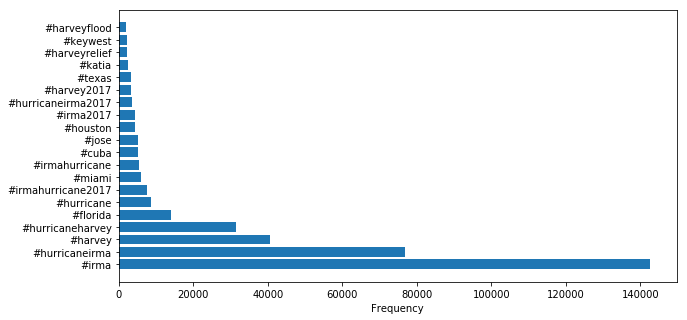

In [345]:
# bar plot
N = 20
x_pos = pd.np.arange(N)
label_width = 0.5
height = 5
plt.figure(figsize=(label_width * N, height))
plt.barh(x_pos, hashtag_counts[:N])
plt.yticks(x_pos, hashtag_counts[:N].index.tolist())
plt.xlabel('Frequency')
plt.show()

## Plot time series

How many unique tweets and users were tweeting about Harvey and Irma over time?

In [308]:
harvey_matcher = re.compile('\#harvey|\#hurricaneharvey')
irma_matcher = re.compile('\#irma|\#hurricaneirma')
tweet_df_combined = tweet_df_combined.assign(harvey=tweet_df_combined.loc[:, 'text'].apply(lambda x: len(match_text(harvey_matcher, x.lower())) > 0))
tweet_df_combined = tweet_df_combined.assign(irma=tweet_df_combined.loc[:, 'text'].apply(lambda x: len(match_text(irma_matcher, x.lower())) > 0))

In [309]:
print(datetime.strftime(tweet_df_combined.loc[:, 'created_at'][0].to_pydatetime(), day_fmt))

09-09-2017


In [313]:
# aggregate by day
def convert_date(x, day_fmt):
    try:
        converted = datetime.strftime(x.to_pydatetime(), day_fmt)
        return converted
    except Exception, e:
        print('error with date %s, type=%s'%(x, type(x)))
        return ''
day_fmt = '%m-%d-%Y'
tweet_df_combined_days = tweet_df_combined.loc[:, 'created_at'].apply(lambda x: convert_date(x, day_fmt))
tweet_df_combined = tweet_df_combined.assign(created_at_day=tweet_df_combined_days)
tweet_df_combined = tweet_df_combined[tweet_df_combined.loc[:, 'created_at_day'] != '']
harvey_counts = tweet_df_combined.loc[:, ['created_at_day', 'harvey']].groupby('created_at_day').apply(lambda x: x.loc[:, 'harvey'].sum())
irma_counts = tweet_df_combined.loc[:, ['created_at_day', 'irma']].groupby('created_at_day').apply(lambda x: x.loc[:, 'irma'].sum())

In [314]:
# get rid of empty counts
harvey_counts = harvey_counts.loc[[x for x in harvey_counts.index if x !=  '']]
irma_counts = irma_counts.loc[[x for x in irma_counts.index if x != '']]
print(harvey_counts)
print(irma_counts)

created_at_day
08-16-2017       3
08-17-2017      29
08-18-2017      63
08-19-2017      45
08-20-2017      21
08-21-2017      17
08-22-2017      44
08-23-2017     189
08-24-2017    1478
08-25-2017    5953
08-26-2017    6651
08-27-2017    7194
08-28-2017    8785
08-29-2017    8571
08-30-2017    8424
08-31-2017    5724
09-01-2017    3946
09-02-2017    2743
09-03-2017    2238
09-04-2017    1256
09-05-2017    1065
09-06-2017     901
09-07-2017     774
09-08-2017    3004
09-09-2017    8614
09-10-2017     473
09-11-2017     395
09-12-2017     352
09-13-2017     359
09-14-2017      80
dtype: int64
created_at_day
08-16-2017         1
08-17-2017         1
08-18-2017         2
08-19-2017         1
08-20-2017         3
08-21-2017         1
08-22-2017         1
08-23-2017         2
08-24-2017         1
08-25-2017         2
08-26-2017         2
08-27-2017        25
08-28-2017         8
08-29-2017         4
08-30-2017       119
08-31-2017       392
09-01-2017       414
09-02-2017       269
09-03-201

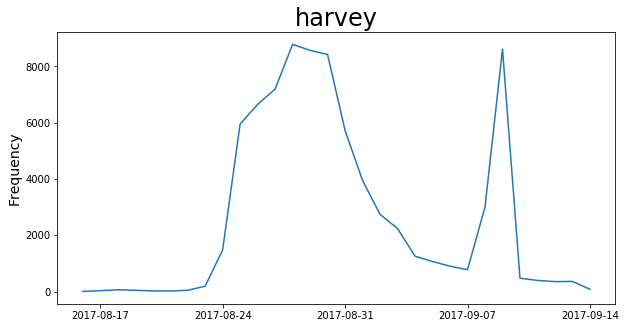

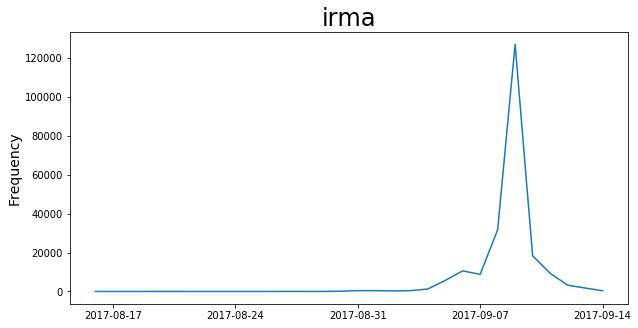

In [315]:
from itertools import izip
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plot_names = ['harvey', 'irma']
count_list = [harvey_counts, irma_counts]
title_font = 24
label_size = 14
width = 10
height = 5
ylabel = 'Frequency'
for plot_name, counts in izip(plot_names, count_list):
    counts.sort_index(inplace=True)
    count_dates = [datetime.strptime(x, day_fmt) for x in counts.index]
    plt.figure(figsize=(width, height))
    plt.plot(count_dates, counts)
    plt.title(plot_name, fontsize=title_font)
    plt.ylabel(ylabel, fontsize=label_size)

It seems that Harvey had more steady attention whereas Irma had a bigger burst of attention.

## Distribution over space
Where were the Harvey and Irma tweets posted from?

We can use [this](https://stackoverflow.com/questions/40491340/plotting-a-map-with-geopy-and-matplotlib-in-jupyter-notebook#40494221) plotting code.

TODO: install basemap [here](https://pypi.python.org/pypi/basemap)

## Ambiguity: language-first
How can we find tweets with ambiguous location?

One way is to look for tweets without a named entity.

In [320]:
from ner import HttpNER
tagger = HttpNER(host='localhost', port=8080)
test = "University of California is located in California, United States"
ents = tagger.get_entities(test)

error: [Errno 111] Connection refused

That's not going to work! Better try the NER extractor.

In [325]:
from nltk.tag.stanford import CoreNLPNERTagger

ImportError: No module named CoreNLPNERTagger

Regular part of speech tagger?

In [329]:
from nltk import word_tokenize, pos_tag
test = "University of California is located in California, United States"
pos_tags = pos_tag(word_tokenize(test))
print(pos_tags)

[('University', 'NNP'), ('of', 'IN'), ('California', 'NNP'), ('is', 'VBZ'), ('located', 'VBN'), ('in', 'IN'), ('California', 'NNP'), (',', ','), ('United', 'NNP'), ('States', 'NNPS')]


Looks good so far! Let's see how well it does on some sample tweets.

In [332]:
pd.np.random.seed(123)
from nltk.tokenize.casual import TweetTokenizer
sample_size = 10
sample_tweets = pd.np.random.choice(tweet_df_combined.loc[:, 'text'], sample_size, replace=False)
print(sample_tweets)
tokenizer = TweetTokenizer()
sample_tweet_tags = [pos_tag(tokenizer.tokenize(t)) for t in sample_tweets]
for tags in sample_tweet_tags:
    print(' '.join(['/'.join(t) for t in tags]))

[ '"#IRMA is a CAT 5 once again!! https:// twitter.com/RyanNBC6/statu s/906361605088260097 \xe2\x80\xa6"'
 u'RT @FLOTUS: Recovery efforts in #Texas will be long term. If you were affected by #Harvey, apply for help &amp; resources at   https://t.co/V6W\u2026'
 u'RT @umksig: Kappa Sig will be donating $0.25 for every RT and $0.10 for every like this tweet gets towards #HurricaneHarvey relief efforts\u2026'
 '"#enDirecto as\xc3\xad va el paso del hurac\xc3\xa1n #Irma por Florida EEUU https:// youtu.be/r0qtNh39U4E trafficMcbo alcabalasmcbo"'
 u'RT @KPRC2Sara: This man is a preacher checking for people inside cars at 610 &amp; 288 PC Brian Roberson Jr @KPRC2 #Harvey https://t.co/NJx58ZN\u2026'
 u'RT @RyanBingham: Thinking of everyone in the Houston area. For ways to help victims of #HurricaneHarvey please follow this link https://t.c\u2026'
 u'RT @SalArmyEDS: #SalvationArmy #Pasadena Corps in #Houston taking in flood evacuees (and  puppies) this morning.  #Harvey2017\u2026 '
 u'RT @Houston

Notes:

- usernames tagged as common nouns (`RyanBingham`)
- hashtags sometimes tagged as proper nouns (`#Harvey`) but not always (`#Pasadena/NN`)
- RT tagged as proper noun

Rule-based attempt: 
- remove tweets that have more than one NNP tag (not counting RT and hashtag tokens)

In [346]:
print(tweet_df_combined.shape[0])

292968


In [348]:
# warning: takes about 10 minutes for 300K tweets
tweets_tagged = tweet_df_combined.loc[:, 'text'].apply(lambda x: pos_tag(tokenizer.tokenize(x)))

In [352]:
print(tweets_tagged[0])

[(u'"', 'NN'), (u'NOW', 'NNP'), (u':', ':'), (u'I', 'PRP'), (u'-', ':'), (u'95', 'CD'), (u'in', 'IN'), (u'West', 'NNP'), (u'Palm', 'NNP'), (u'Beach', 'NNP'), (u'.', '.'), (u'Hurricane', 'NNP'), (u'warning', 'NN'), (u'and', 'CC'), (u'curfew', 'NN'), (u'are', 'VBP'), (u'in', 'IN'), (u'effect', 'NN'), (u'.', '.'), (u'#HurricaneIrma', 'CC'), (u'pic.twitter.com/DOt09uiXqJ', 'JJ'), (u'"', 'NN')]


In [368]:
PROPER_NOUN = 'NNP'
PROPER_NOUN_MATCHER = re.compile('NNPS*')
IGNORE_MATCHER = re.compile('RT|#\w+')
def count_proper_nouns(token_tags):
    # ignore RT or hashtag tokens
    token_tags = filter(lambda x: not IGNORE_MATCHER.match(x[0]), token_tags)
    proper_noun_count = len(filter(lambda x: PROPER_NOUN_MATCHER.match(x[1]), token_tags))
    return proper_noun_count
proper_noun_counts = tweets_tagged.apply(count_proper_nouns)

In [369]:
print(tweets_tagged.head())
print(proper_noun_counts.head())

0    [(", NN), (NOW, NNP), (:, :), (I, PRP), (-, :)...
1    [(", NN), (Meanwhile, RB), (in, IN), (Hialeah,...
2    [(", JJ), (Yemaja, NNP), (and, CC), (Osun, NNP...
3    [(", JJ), (NEW, NN), (:, :), (This, DT), (vide...
4    [(", JJ), (LATEST, NN), (:, :), (Hurricane, NN...
Name: text, dtype: object
0    5
1    2
2    2
3    4
4    8
Name: text, dtype: int64


In [370]:
tweet_tag_df = pd.concat([tweets_tagged, proper_noun_counts], axis=1)
tweet_tag_df.columns = ['tagged_tweet', 'proper_noun_count']
# filter for non-proper nouns
non_proper_tweets = tweet_tag_df[tweet_tag_df.loc[:, 'proper_noun_count'] == 0]
print('%d tweets without proper nouns'%(non_proper_tweets.shape[0]))

45109 tweets without proper nouns


Let's see some examples.

In [374]:
pd.np.random.seed(123)
sample_size = 1000
non_proper_sample = pd.np.random.choice(non_proper_tweets.loc[:, 'tagged_tweet'], size=sample_size, replace=False)
for s in non_proper_sample:
    print(' '.join(['/'.join(x) for x in s]))
    print('\n')

SHARE/NN !/. !/. !/. #us/JJ #IrmaHurricane/NN #shelters/NNS #Weather/VBP #Irma/JJ #FloridaEvacuation/NN https://t.co/sewbsT7F7H/NN


#HurricaneIrma/JJ #HAARP/MD look/VB it/PRP up/RP


"/JJ #HurricaneIrma/NNP #Florida/NNP #FloridaProblems/VBZ #HunkerDown/JJ https://www/NN ./. instagram.com/p/BYzbSapF_RJ3/VB 3jbQDJEonGLLj/CD -/: SIa/NN 9P1d3c6iE0/CD //NN …/NN "/NN


"/NN Decided/VBD to/TO board/NN up/RP one/CD window/NN in/IN the/DT house/NN giving/VBG us/PRP a/DT more/RBR guaranteed/JJ "/JJ safe/JJ spot/NN "/NN should/MD things/NNS go/VB awry/RB ./. #Irma/VB #Florida/JJ #RideItOut/NN "/NN


RT/NNP @NASA_SPoRT/NN :/: The/DT eye/NN of/IN a/DT category/NN 5/CD hurricane/NN ./. #Irma/JJ #GOES16/NN https://t.co/eATVZspJZx/NN


RT/NNP @MikeHudema/NN :/: Flooding/NN caused/VBN by/IN #Harvey/NN has/VBZ toppled/VBN two/CD oil/NN storage/NN tanks/NNS ,/, releasing/VBG 30,000/CD gallons/NNS of/IN crude/JJ oil/NN :/: …/NN


RT/JJ @HoustonPubMedia/NN :/: 2,500/CD homes/NNS may/MD experience/VB flood

Hmm, not much ambiguity except for a few:

- "/JJ **#WPBVAMC/JJ** staff/NN have/VBP been/VBN working/VBG hard/JJ ahead/RB of/IN #HurricaneIrma/NN to/TO ensure/VB our/PRP$ #veteran/NN inpatients/NNS are/VBP safe/JJ &/CC ops/NNS flow/VBP smoothly/RB pic.twitter.com/eHO0P2mKYa/JJ "/NN 
- "/JJ **#NMB/NN** is/VBZ boarded/VBN up/RP and/CC hunkered/VBD down/RB ./. Please/VB stay/JJ safe/JJ and/CC off/IN the/DT roads/NNS until/IN #HurricaneIrma/JJ passes/NNS ./. #NMBStormReady/JJ pic.twitter.com/nJoxRcoz0E/NN "/NN
- "/NN Watching/VBG **the/DT hurricane/NN** on/IN the/DT news/NN makes/VBZ me/PRP anxious/JJ especially/RB ,/, when/WRB I/PRP know/VBP people/NNS in/IN #HurricaneIrma/JJ wake.Stay/NN safe/JJ everyone/NN #PrayForFlorida/NN "/NN
- "/NN During/IN #Harvey/NNP **our/PRP\$ street/NN** started/VBD to/TO flood/VB drains/NNS couldn't/VB process/NN the/DT rain/NN fall/NN ./. "/NN
- "/RB #Irma/NN this/DT will/MD be/VB the/DT first/JJ time/NN since/IN 9/11/CD that/IN **an/DT entire/JJ state's/NN** airport/NN system/NN will/MD be/VB shut/VBN down/RP ./. "/VB
- "/NNS Something/VBG for/IN me/PRP to/TO read/VB tomorrow/NN with/IN **the/DT parks/NNS** shut/VBD due/JJ to/TO #Irma/VB "/NN
- "/JJ Why/WRB didn't/NN they/PRP open/VBP both/DT sides/NNS of/IN **highway/NN** ?/. #irma/CD "/NN
- RT/NNP @JRuder1/NN :/: This/DT is/VBZ why/WRB you/PRP don/VBP ’/JJ t/NN dork/NN around/RB in/IN flood/NN waters/NNS ./. Floating/VBG pile/NN of/IN fire/NN ants/NNS from/IN **a/DT local/JJ retention/NN pond/NN** #Harvey/NNP https://t.co…/NN
- Just/RB saw/VBD a/DT helicopter/NN flying/VBG right/RB on/IN **championship/NN forest/JJS** hoping/VBG people/NNS get/VBP recused/VBN soon/RB #Houstonflood/NNP #Harvey/NN
- "/JJ Storm/NN shutters/NNS up/RP ,/, booze/RB bought/VBD ,/, last/JJ run/NN to/TO **the/DT store/NN** complete/JJ ,/, cold/JJ medicine/NN begun/VBN .../: lets/VBZ do/VBP this/DT #irma/NN "/NN
- "/NN **This/DT storm/NN** has/VBZ not/RB even/RB remotely/RB started/VBN yet/RB ,/, and/CC I/PRP probably/RB lost/VBD trees/NNS already/RB ./. #Irma/VB "/NN
- My/PRP\$ heart/NN breaks/VBZ as/IN I/PRP watch/VBP **my/PRP\$ wonderful/JJ city/NN** be/VB ravaged/VBN by/IN #HurricaneHarvey/NNP #HoustonFloods/NNS https://t.co/JTzJB3YEx3/NN
- made/VBD a/DT \$/\$ 3/CD donation/NN to/TO the/DT @RedCross/NN to/TO aid/VB those/DT affected/VBN by/IN #HurricaneHarvey/NN at/IN my/PRP\$ **local/JJ @DollarTree/NN**
- "/NN There/EX are/VBP 54/CD six/CD toed/NN cats/NNS at/IN **the/DT #HemingwayHouse/NN** ./. Wish/JJ people/NNS could've/VBP taken/VBN a/DT few/JJ with/IN them/PRP on/IN their/PRP\$ way/NN out/IN of/IN town/NN ./. #KeyWest/JJS #Irma/JJ pic.twitter.com/1hwEHvwDHu/NN "/NN
- "/NN ./. @FLGovScott/NN :/: "/NN This/DT is/VBZ a/DT deadly/RB major/JJ storm/NN and/CC **our/PRP\$ state/NN** has/VBZ never/RB seen/VBN anything/NN like/IN this/DT ./. "/VB #irma/JJ pic.twitter.com/LHViYo92Ur/NN "/NN
- RT/NNP @SylvesterTurner/NN :/: Not/RB the/DT time/NN for/IN negativity/NN when/WRB people/NNS are/VBP giving/VBG up/RP their/PRP\$ lives/NNS for/IN **this/DT city/NN** ./. #Harvey/JJ #StevePerezRIP/NN
- "/NNS So/RB good/JJ to/TO see/VB **a/DT community/NN** and/CC **a/DT country/NN** come/VB together/RB to/TO support/VB and/CC prepare/VB for/IN the/DT hurricane/NN #irma/NNP "/NN
- "/NN Following/VBG #FSU/JJ alum/JJ @TWCChrisBruin/NN as/IN he/PRP covers/VBZ **my/PRP\$ hometown/NN** ,/, #Tampa/NNP ,/, for/IN @WeatherChannel/NN for/IN #Irma/NNP ./. "/NN
- RT/NNP @mike_58stingray/NN :/: Y'all/NN be/VB careful/JJ stay/JJ home/NN swimming/NN shark/NN **on/IN 290/CD** #PrayforTexas/JJ #Harvey/NNP https://t.co/gYerd5OqV8/NN
- "/NN when/WRB @bathbodyworks/NNS candles/NNS are/VBP on/IN sale/NN but/CC **your/PRP\$ local/JJ store/NN** is/VBZ closed/VBN for/IN #HurricaneIrma/NN .../: any/DT chance/NN I/PRP can/MD get/VB a/DT (/( literal/JJ )/) raincheck/NN ?/. "/NN

Most ambiguity seems to stem from acronyms, such as `NMB` (North Miami Beach). So maybe this would be the most pertinent information for disaster responders to seek.

Sanity check: do the tweets containing proper nouns also exhibit any ambiguity?

In [373]:
pd.np.random.seed(123)
proper_tweets = tweet_tag_df[tweet_tag_df.loc[:, 'proper_noun_count'] > 0]
sample_size = 100
proper_sample = pd.np.random.choice(proper_tweets.loc[:, 'tagged_tweet'], size=sample_size, replace=False)
for s in proper_sample:
    print(' '.join(['/'.join(x) for x in s]))
    print('\n')

"/NN In/IN the/DT path/NN of/IN Hurricane/NNP #Irma/NNP ?/. Here/RB ’/VBZ s/VB what/WP to/TO do/VB before/IN the/DT storm/NN arrives/VBZ :/: http/NN ://NNP //NNP cnn.it/2gT9QST/NN pic.twitter.com/NnlrTRA4MJ/NN "/NN


RT/JJ @funder/NN :/: Be/NNP safe/JJ in/IN #Texas-let/JJ us/PRP know/VBP if/IN there/EX is/VBZ anything/NN we/PRP can/MD help/VB get/VB the/DT word/NN out/IN about/RB after/IN #Harvey/JJ hits/NNS ./. We're/NNP here/RB to/TO help/VB !/. #/# …/NN


"/JJ Little/JJ Couple/NNP ’/NNP s/NN Jen/NNP Arnold/NNP ,/, Bill/NNP Klein/NNP Evacuate/NNP Due/NNP To/TO Hurricane/NNP Irma/NNP https://www/NN ./. inquisitr.com/4486773/little/JJ -/: couple-stars-jen-arnold-bill-klein-and-kids-evacuate-hurricane-forces-rush-departure-from-new-home/JJ //NN …/NNP #HurricaneIrma/NNP #LittleCouple/NNP #TheLittleCouple/NNP "/NNP


RT/JJ @NewYorker/NN :/: A/DT Facebook/NNP group/NN formed/VBD after/IN a/DT storm/NN hit/VBN Louisiana/NNP last/JJ year/NN is/VBZ helping/VBG the/DT rescue/NN efforts/NNS dur

- RT/NNP @mcgill256/NN :/: Link/NNP has/VBZ list/NN of/IN shelters/NNS 4/CD ppl/NNS who/WP didn't/VBP leave/VBP **the/DT keys/NNS** b4/VBP Irma/NNP #Irma/NNP #hurricaneirma2017/NNP #FLKeys/NNP #FloridaKeys/NNP https://t…/NN
- "/JJ Irma/NNP veered/VBD westward/RB ./. The/DT **east/JJ coast/NN** can/MD breathing/VB easier/JJR ./. The/DT Gulf/NNP Coast's/NNP in/IN danger/NN ./. I'm/NNP ok/NN ./. Thanks/NNS ./. #Irma/CD "/NN
- "/NNS @AuntSherryGA/VBP keeping/VBG you/PRP in/IN my/PRP$ thoughts/NNS &/CC prayers/NNS as/IN #Irma/JJ approaches/NNS **our/PRP\$ area/NN** ,/, stay/VB safe/JJ ,/, I/PRP love/VBP you/PRP &/CC miss/VB seeing/VBG you/PRP at/IN one/CD of/IN Casey's/NNP Gigs/NNP "/NN
- "/RB Good/JJ morning/NN ./. Evacuation/NN order/NN in/IN #Ocala/NN ?/. We/PRP are/VBP at/IN **#TheVillages/NNS** and/CC we/PRP do/VBP not/RB know/VB what/WP to/TO do/VB ./. Please/VB HELP/NNP @OEUinfo/NNP ./. Thanks/NNP #HurricaneIrma/VBD "/NN
- RT/NNP @KPRC2Sara/NN :/: This/DT man/NN is/VBZ a/DT preacher/NN checking/VBG for/IN people/NNS inside/IN cars/NNS **at/IN 610/CD &/CC 288/CD** PC/NN Brian/NNP Roberson/NNP Jr/NNP @KPRC2/NNP #Harvey/NNP https://t.co/NJx58ZN…/NN

The ambiguity in tweets with proper nouns has to do with wide-scope proper nouns such as `the keys`, `east coast`, and `TheVillages` or street names such as `610 & 288`. We also see another example of local-only knowledge with `our area`.

## Ambiguity: user-first
Instead of starting from language, what if we look for people who actually witnessed Harvey and Irma? 

These people would be more likely to use unmarked language, since they are locals as opposed to outside news sources.